In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Reading the dataset

df = pd.read_parquet("schedule_features_2016_2025.parquet")

In [3]:
# Reviewing the dataset info

df.info()

<class 'pandas.DataFrame'>
RangeIndex: 2761 entries, 0 to 2760
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   game_id             2761 non-null   str    
 1   season              2761 non-null   int32  
 2   game_type           2761 non-null   str    
 3   week                2761 non-null   int32  
 4   away_team           2761 non-null   str    
 5   away_score          2760 non-null   float64
 6   home_team           2761 non-null   str    
 7   home_score          2760 non-null   float64
 8   result              2760 non-null   float64
 9   total               2760 non-null   float64
 10  overtime            2760 non-null   float64
 11  away_rest           2761 non-null   int32  
 12  home_rest           2761 non-null   int32  
 13  div_game            2761 non-null   int32  
 14  roof                2761 non-null   str    
 15  surface             2761 non-null   str    
 16  r_away           

In [4]:
# The null values correspond to the following game, which is the SB 2025, let's remove it

df = df.dropna(subset=["home_score", "away_score"]).reset_index(drop=True)

In [5]:
# With the previous values, create some differences like "home_win" "margin" "total_points", "elo_diff", "off_diff", "def_allowed_diff"

df["home_win"] = (df["home_score"] > df["away_score"]).astype(int)
df["margin"] = df["home_score"] - df["away_score"]
df["total_points"] = df["home_score"] + df["away_score"]

df["elo_diff"] = df["r_home"] - df["r_away"]
df["off_diff"] = df["off_epa_pp_home"] - df["off_epa_pp_away"]

# si def_epa_pp_* es "allowed" (EPA permitido), esto queda bien para ventaja del home:
df["def_allowed_diff"] = df["def_epa_pp_away"] - df["def_epa_pp_home"]

df["to_diff"] = df["turnover_rate_away"] - df["turnover_rate_home"]
df["rest_diff"] = df["home_rest"] - df["away_rest"]


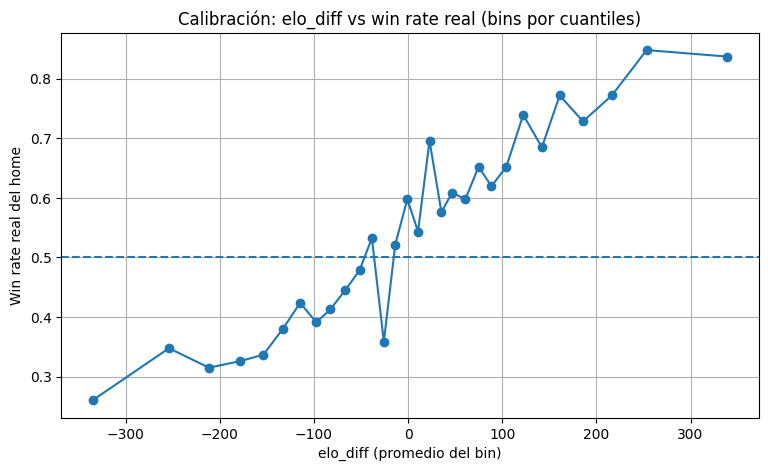

,elo_mid,home_win_rate,n
5,-132.862226,0.380435,92
6,-114.588258,0.423913,92
7,-97.456600,0.391304,92
8,-82.423837,0.413043,92
9,-66.504363,0.445652,92
10,-51.513163,0.478261,92
11,-38.371253,0.532609,92
12,-25.689616,0.358696,92


In [6]:
n_bins = 30
df_plot = df.copy()

# Bins por cuantiles (cada bin con tamaño similar)
df_plot["elo_bin"] = pd.qcut(df_plot["elo_diff"], q=n_bins, duplicates="drop")

# Agregación por bin
g = (df_plot.groupby("elo_bin")
     .agg(
         elo_mid=("elo_diff", "mean"),
         home_win_rate=("home_win", "mean"),
         n=("home_win", "size"),
     )
     .reset_index()
     .sort_values("elo_mid"))

# Plot
plt.figure(figsize=(9,5))
plt.plot(g["elo_mid"], g["home_win_rate"], marker="o")
plt.axhline(0.5, linestyle="--")
plt.xlabel("elo_diff (promedio del bin)")
plt.ylabel("Win rate real del home")
plt.title("Calibración: elo_diff vs win rate real (bins por cuantiles)")
plt.grid(True)
plt.show()

# (opcional) tabla para ver tamaños por bin
g[["elo_mid","home_win_rate","n"]][5:13]

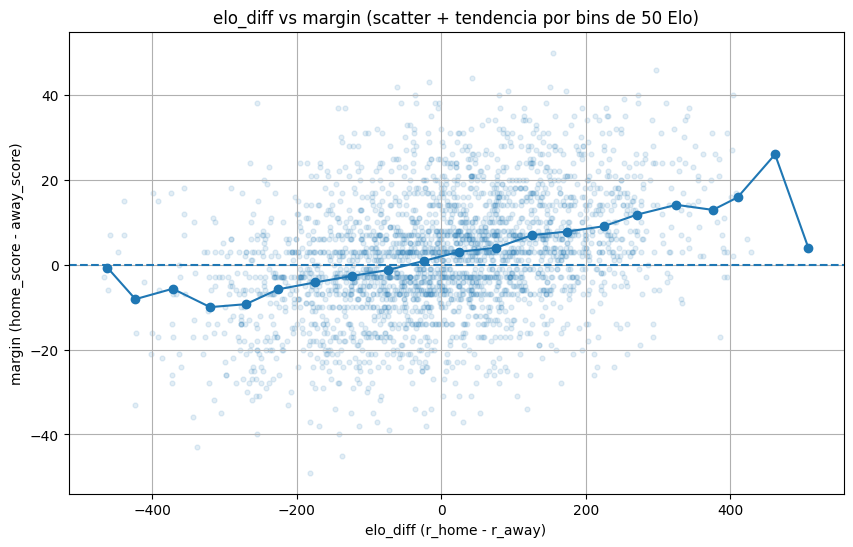

,elo_mid,margin_mean,n
16,325.222986,14.111111,36
17,375.748003,12.916667,24
18,409.814123,15.857143,7
19,461.754430,26.000000,1
20,507.777326,4.000000,1


In [7]:
df_plot = df.copy()

# 1) Scatter
plt.figure(figsize=(10,6))
plt.scatter(df_plot["elo_diff"], df_plot["margin"], alpha=0.12, s=12)

# 2) Tendencia: promedio de margin por bins de elo_diff (bins de ancho fijo)
bin_width = 50
xmin = int(np.floor(df_plot["elo_diff"].min() / bin_width) * bin_width)
xmax = int(np.ceil(df_plot["elo_diff"].max() / bin_width) * bin_width)
bins = np.arange(xmin, xmax + bin_width, bin_width)

df_plot["elo_bin_fixed"] = pd.cut(df_plot["elo_diff"], bins=bins)

trend = (df_plot.groupby("elo_bin_fixed")
         .agg(elo_mid=("elo_diff","mean"),
              margin_mean=("margin","mean"),
              n=("margin","size"))
         .dropna()
         .reset_index()
         .sort_values("elo_mid"))

plt.plot(trend["elo_mid"], trend["margin_mean"], marker="o")

# Líneas guía
plt.axhline(0, linestyle="--")
plt.xlabel("elo_diff (r_home - r_away)")
plt.ylabel("margin (home_score - away_score)")
plt.title("elo_diff vs margin (scatter + tendencia por bins de 50 Elo)")
plt.grid(True)
plt.show()

trend[["elo_mid","margin_mean","n"]].tail()


elo_diff (p1=-357.967, p50=3.943, p99=357.438)


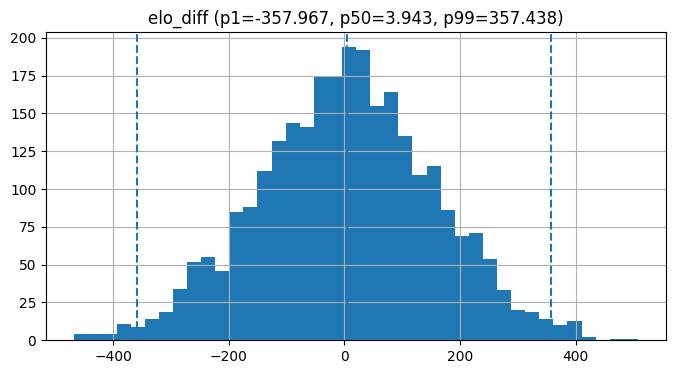

off_diff (p1=-0.359, p50=-0.000, p99=0.371)


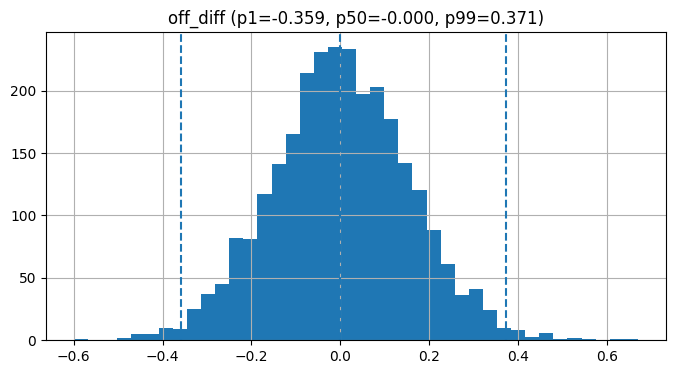

def_allowed_diff (p1=-0.331, p50=0.001, p99=0.318)


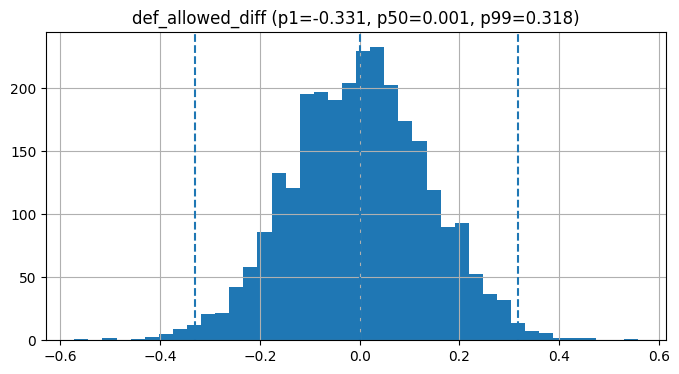

to_diff (p1=-0.024, p50=0.000, p99=0.024)


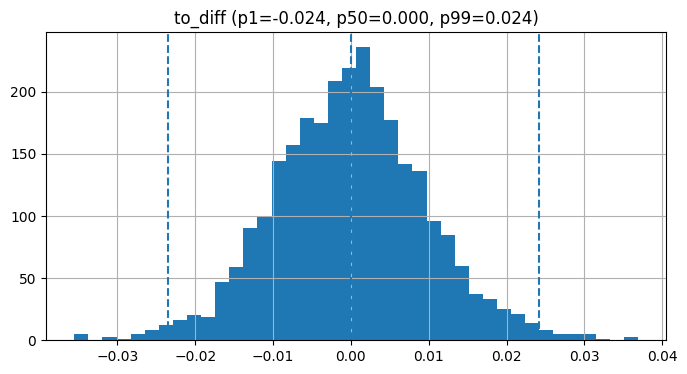

rest_diff (p1=-7.000, p50=0.000, p99=7.000)


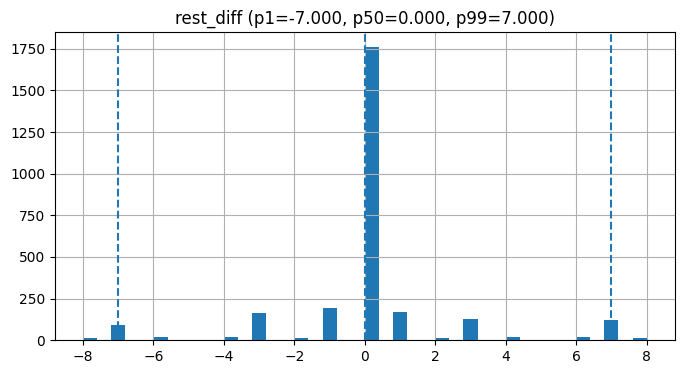

In [8]:
cols = ["elo_diff", "off_diff", "def_allowed_diff", "to_diff", "rest_diff"]

for c in cols:
    p1, p50, p99 = np.percentile(df[c], [1, 50, 99])
    plt.figure(figsize=(8,4))
    plt.hist(df[c], bins=40)
    plt.axvline(p1, linestyle="--")
    plt.axvline(p50, linestyle="--")
    plt.axvline(p99, linestyle="--")
    plt.title(f"{c} (p1={p1:.3f}, p50={p50:.3f}, p99={p99:.3f})")
    print(f"{c} (p1={p1:.3f}, p50={p50:.3f}, p99={p99:.3f})")
    plt.grid(True)
    plt.show()

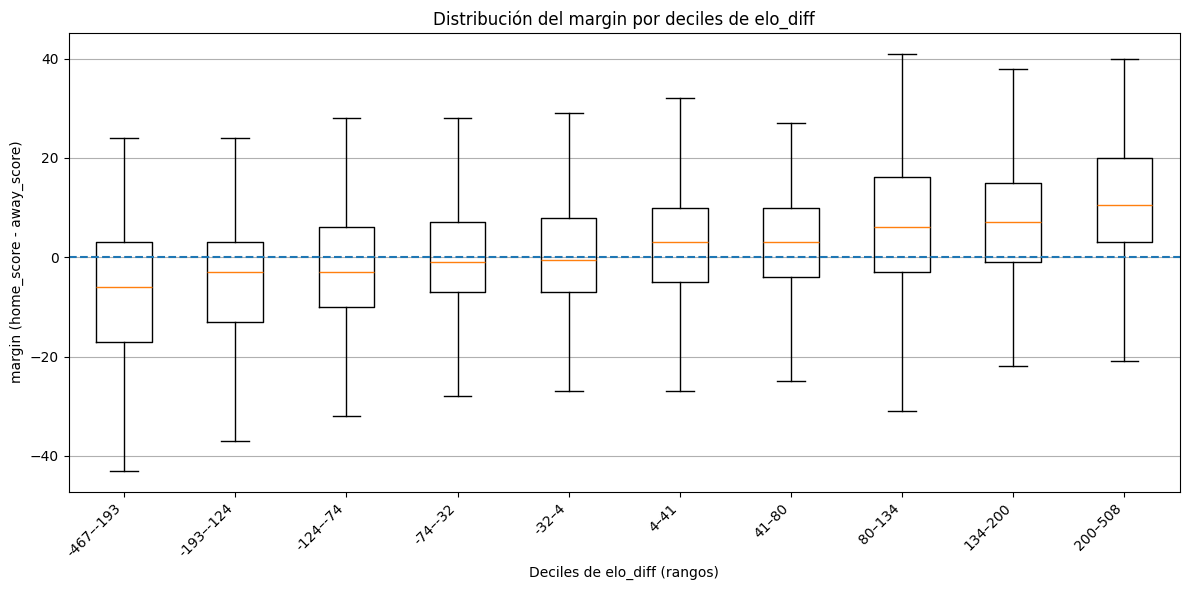

In [9]:
df_plot = df.copy()

# 1) Deciles de elo_diff (qcut asegura tamaños parecidos)
df_plot["elo_decile"] = pd.qcut(df_plot["elo_diff"], q=10, labels=False, duplicates="drop")

# 2) Construir listas de margin por decil (ordenadas)
data = [df_plot.loc[df_plot["elo_decile"] == i, "margin"].values for i in sorted(df_plot["elo_decile"].unique())]

# Etiquetas: rango de elo_diff por decil
bins = pd.qcut(df_plot["elo_diff"], q=10, duplicates="drop")
labels = [f"{interval.left:.0f}–{interval.right:.0f}" for interval in bins.cat.categories]

plt.figure(figsize=(12,6))
plt.boxplot(data, showfliers=False)  # showfliers=True si quieres ver outliers
plt.axhline(0, linestyle="--")
plt.xticks(range(1, len(labels)+1), labels, rotation=45, ha="right")
plt.xlabel("Deciles de elo_diff (rangos)")
plt.ylabel("margin (home_score - away_score)")
plt.title("Distribución del margin por deciles de elo_diff")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

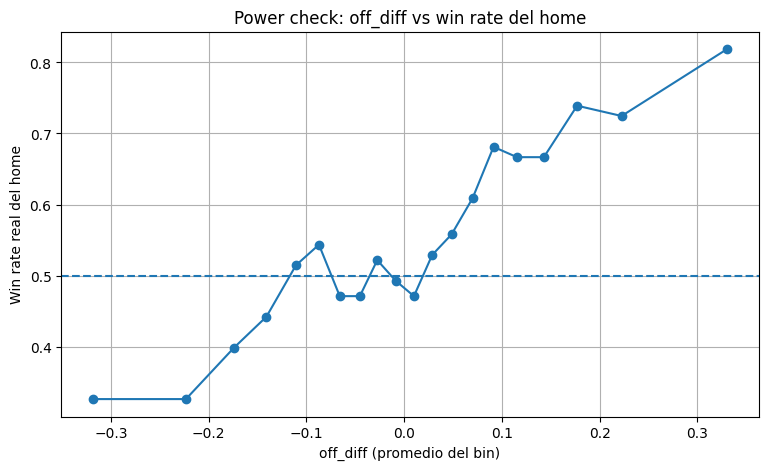

,x_mid,win_rate,n
0,-0.318406,0.326087,138
1,-0.223284,0.326087,138
2,-0.174019,0.398551,138
3,-0.140926,0.442029,138
4,-0.110695,0.514493,138


In [10]:
def winrate_by_bins(df, xcol, ycol="home_win", n_bins=20, title=None):
    d = df[[xcol, ycol]].copy()
    d["bin"] = pd.qcut(d[xcol], q=n_bins, duplicates="drop")
    g = (d.groupby("bin")
         .agg(x_mid=(xcol, "mean"),
              win_rate=(ycol, "mean"),
              n=(ycol, "size"))
         .reset_index()
         .sort_values("x_mid"))
    
    plt.figure(figsize=(9,5))
    plt.plot(g["x_mid"], g["win_rate"], marker="o")
    plt.axhline(0.5, linestyle="--")
    plt.xlabel(f"{xcol} (promedio del bin)")
    plt.ylabel("Win rate real del home")
    plt.title(title or f"{xcol} vs win rate (bins por cuantiles)")
    plt.grid(True)
    plt.show()
    return g

g_off = winrate_by_bins(df, "off_diff", n_bins=20, title="Power check: off_diff vs win rate del home")
g_off[["x_mid","win_rate","n"]].head()

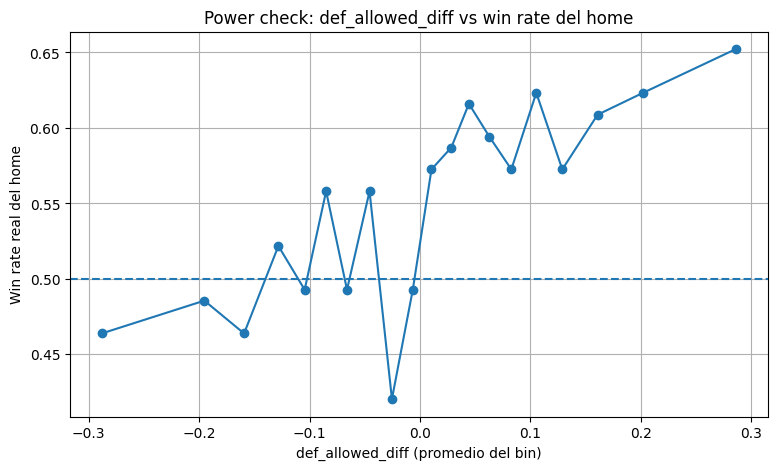

,x_mid,win_rate,n
0,-0.288113,0.463768,138
1,-0.195208,0.485507,138
2,-0.159245,0.463768,138
3,-0.128208,0.521739,138
4,-0.104418,0.492754,138


In [11]:
g_def = winrate_by_bins(df, "def_allowed_diff", n_bins=20, title="Power check: def_allowed_diff vs win rate del home")
g_def[["x_mid","win_rate","n"]].head()

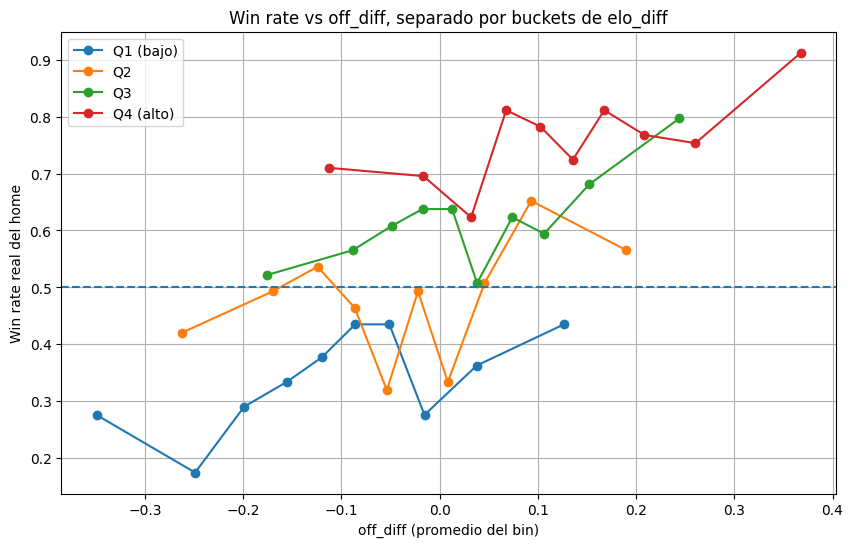

In [12]:
def winrate_table_by_bins(df, xcol, ycol="home_win", n_bins=10):
    d = df[[xcol, ycol]].copy()
    d["bin"] = pd.qcut(d[xcol], q=n_bins, duplicates="drop")
    g = (d.groupby("bin")
         .agg(x_mid=(xcol, "mean"),
              win_rate=(ycol, "mean"),
              n=(ycol, "size"))
         .reset_index()
         .sort_values("x_mid"))
    return g

df2 = df.copy()
df2["elo_bucket"] = pd.qcut(df2["elo_diff"], q=4, labels=["Q1 (bajo)","Q2","Q3","Q4 (alto)"])

plt.figure(figsize=(10,6))

for label, sub in df2.groupby("elo_bucket"):
    g = winrate_table_by_bins(sub, "off_diff", n_bins=10)
    plt.plot(g["x_mid"], g["win_rate"], marker="o", label=str(label))

plt.axhline(0.5, linestyle="--")
plt.xlabel("off_diff (promedio del bin)")
plt.ylabel("Win rate real del home")
plt.title("Win rate vs off_diff, separado por buckets de elo_diff")
plt.grid(True)
plt.legend()
plt.show()

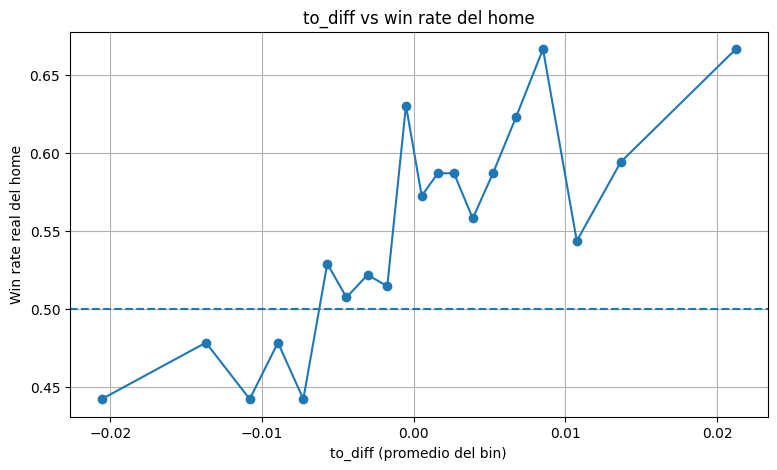

,x_mid,win_rate,n
0,-0.020572,0.442029,138
1,-0.013703,0.478261,138
2,-0.010814,0.442029,138
3,-0.008954,0.478261,138
4,-0.007280,0.442029,138


In [13]:
g_to = winrate_by_bins(df, "to_diff", n_bins=20, title="to_diff vs win rate del home")
g_to[["x_mid","win_rate","n"]].head()

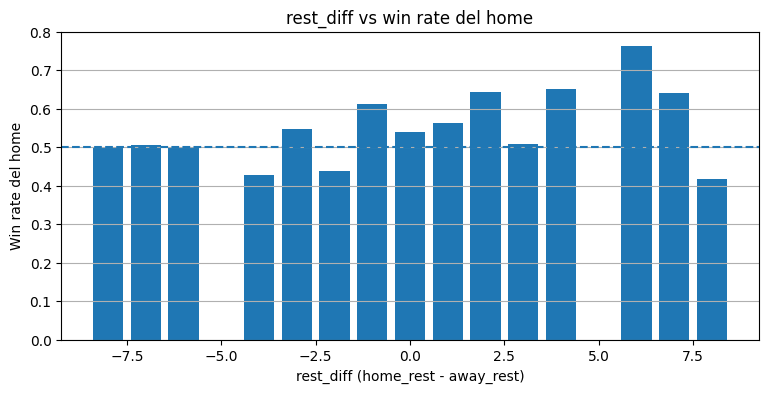

,rest_diff,win_rate,n
0,-8,0.500000,14
1,-7,0.505495,91
2,-6,0.500000,18
3,-4,0.428571,21
4,-3,0.546584,161


In [14]:
import matplotlib.pyplot as plt

g_rest = (df.groupby("rest_diff")
          .agg(win_rate=("home_win","mean"), n=("home_win","size"))
          .reset_index()
          .sort_values("rest_diff"))

plt.figure(figsize=(9,4))
plt.bar(g_rest["rest_diff"], g_rest["win_rate"])
plt.axhline(0.5, linestyle="--")
plt.xlabel("rest_diff (home_rest - away_rest)")
plt.ylabel("Win rate del home")
plt.title("rest_diff vs win rate del home")
plt.grid(True, axis="y")
plt.show()

g_rest.head()


/tmp/ipykernel_60001/61870871.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


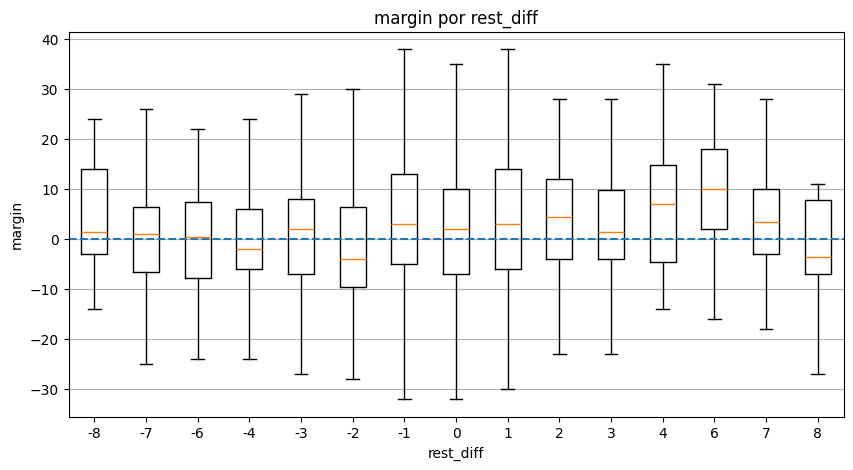

In [15]:
data = [df.loc[df["rest_diff"]==x, "margin"].values for x in g_rest["rest_diff"]]
labels = [str(x) for x in g_rest["rest_diff"]]

plt.figure(figsize=(10,5))
plt.boxplot(data, labels=labels, showfliers=False)
plt.axhline(0, linestyle="--")
plt.xlabel("rest_diff")
plt.ylabel("margin")
plt.title("margin por rest_diff")
plt.grid(True, axis="y")
plt.show()

In [16]:
df["roof"] = df["roof"].astype(str).str.strip().str.lower()
df["surface"] = df["surface"].astype(str).str.strip().str.lower()

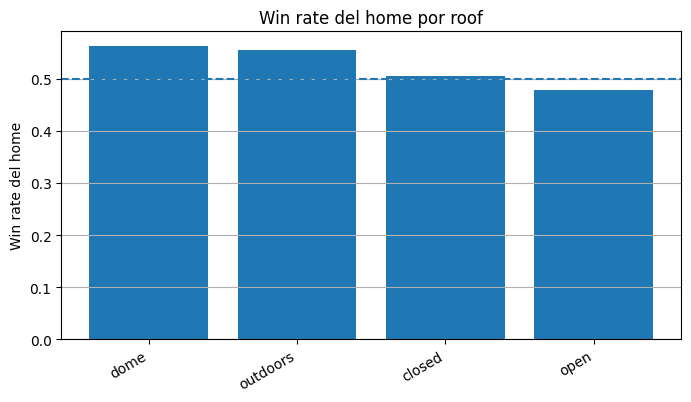

,roof,win_rate,n
1,dome,0.562648,423
3,outdoors,0.555498,1919
0,closed,0.505405,370
2,open,0.479167,48


In [17]:
g_roof = (df.groupby("roof")
          .agg(win_rate=("home_win","mean"), n=("home_win","size"))
          .reset_index()
          .sort_values("win_rate", ascending=False))

plt.figure(figsize=(8,4))
plt.bar(g_roof["roof"], g_roof["win_rate"])
plt.axhline(0.5, linestyle="--")
plt.ylabel("Win rate del home")
plt.title("Win rate del home por roof")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y")
plt.show()

g_roof

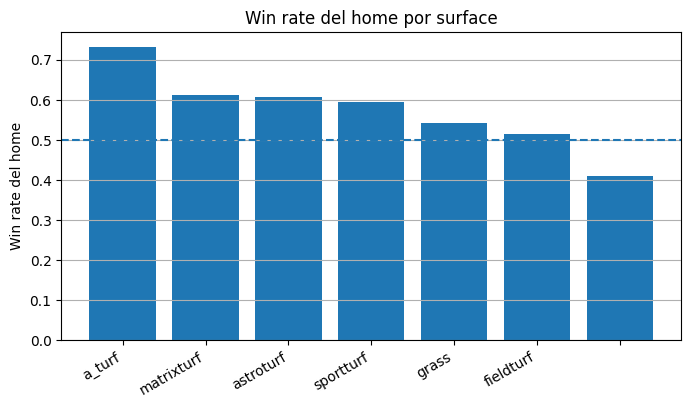

,surface,win_rate,n
1,a_turf,0.732394,71
5,matrixturf,0.611765,170
2,astroturf,0.606838,117
6,sportturf,0.593333,150
4,grass,0.542581,1550
3,fieldturf,0.515198,658
0,,0.409091,44


In [18]:
g_surface = (df.groupby("surface")
             .agg(win_rate=("home_win","mean"), n=("home_win","size"))
             .reset_index()
             .sort_values("win_rate", ascending=False))

plt.figure(figsize=(8,4))
plt.bar(g_surface["surface"], g_surface["win_rate"])
plt.axhline(0.5, linestyle="--")
plt.ylabel("Win rate del home")
plt.title("Win rate del home por surface")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y")
plt.show()

g_surface

/tmp/ipykernel_60001/3153213849.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=cats, showfliers=False)


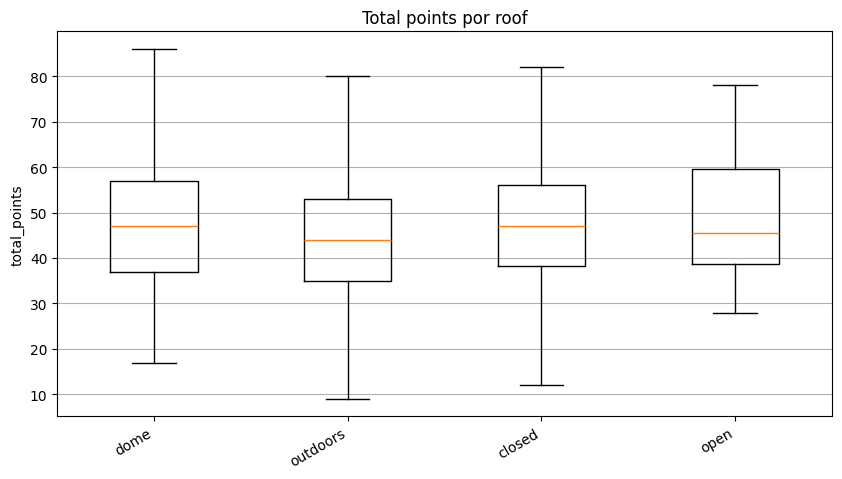

In [19]:
cats = list(g_roof["roof"])
data = [df.loc[df["roof"]==c, "total_points"].values for c in cats]

plt.figure(figsize=(10,5))
plt.boxplot(data, labels=cats, showfliers=False)
plt.ylabel("total_points")
plt.title("Total points por roof")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y")
plt.show()

/tmp/ipykernel_60001/3228248878.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=cats, showfliers=False)


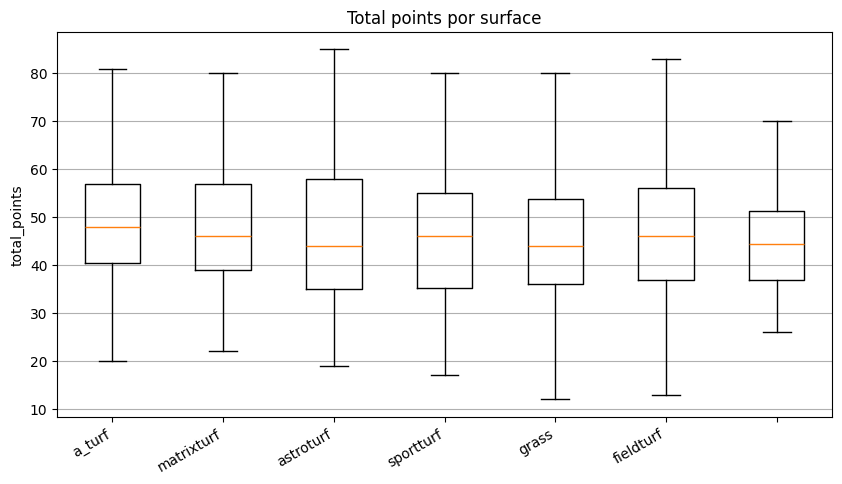

In [20]:
cats = list(g_surface["surface"])
data = [df.loc[df["surface"]==c, "total_points"].values for c in cats]

plt.figure(figsize=(10,5))
plt.boxplot(data, labels=cats, showfliers=False)
plt.ylabel("total_points")
plt.title("Total points por surface")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y")
plt.show()

In [21]:
df["roof"] = df["roof"].astype(str).str.strip().str.lower()
df["surface"] = df["surface"].astype(str).str.strip().str.lower()
df["surface"] = df["surface"].replace({"": "unknown"})

df["is_grass"] = (df["surface"] == "grass").astype(int)
df["is_dome"] = (df["roof"] == "dome").astype(int)
df["is_retractable"] = df["roof"].isin(["open", "closed"]).astype(int)
df["is_outdoors"] = (df["roof"] == "outdoors").astype(int)

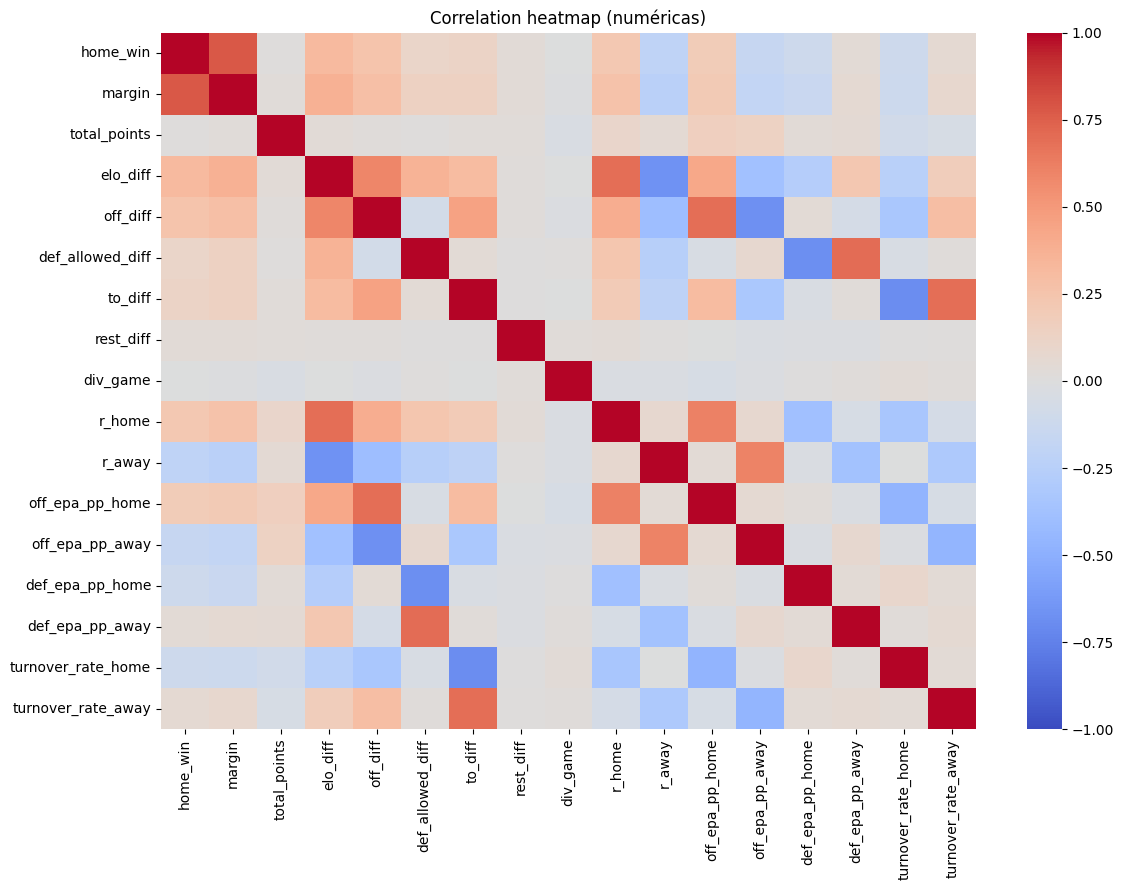

In [22]:
# solo numéricas (excluye IDs y strings)
num_cols = df.select_dtypes(include=[np.number]).columns

# (opcional) elige un subconjunto más útil para modelado
cols = [
    "home_win", "margin", "total_points",
    "elo_diff", "off_diff", "def_allowed_diff", "to_diff", "rest_diff",
    "div_game",
    "r_home", "r_away",
    "off_epa_pp_home", "off_epa_pp_away",
    "def_epa_pp_home", "def_epa_pp_away",
    "turnover_rate_home", "turnover_rate_away",
]

cols = [c for c in cols if c in df.columns]

corr = df[cols].corr(numeric_only=True)

plt.figure(figsize=(12,9))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Correlation heatmap (numéricas)")
plt.tight_layout()
plt.show()
